In [18]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
tqdm.pandas()

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset carregado, colunas de link, autor e data removidas.

Baseado na visualização, as 3 categorias mais frequentes estão muito acima das demais, isso será levado em consideração depois do pré-processamento do texto

In [19]:
dados = pd.read_json('datasetNews.json', lines = True)
dados = dados.drop(columns=['link', 'authors', 'date'])
dados.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [20]:
dados["category"].value_counts()

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

Realizamos o tratamento e processamento inicial do texto, para mais informações consulte a bibliografia.

In [21]:
stopwords_en = set(stopwords.words('english'))

def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    text = [word for word in text.split() if word not in list(stopwords_en)]
    
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence)

dados['headline_processado'] = dados.headline.apply(datacleaning)
dados['desc_processado'] = dados.short_description.apply(datacleaning)
dados['texto_tot'] = dados['headline_processado'] + dados['desc_processado']
dados.head()

,headline,category,short_description,headline_processado,desc_processado,texto_tot
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,million americans roll sleeves omicrontargeted...,health experts say early predict whether deman...,million americans roll sleeves omicrontargeted...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,american airlines flyer charge ban life punch ...,subdue passengers crew flee back aircraft conf...,american airlines flyer charge ban life punch ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",funniest tweet cat dog week sept,dog dont understand could eat,funniest tweet cat dog week septdog dont under...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",funniest tweet parent week sept,accidentally put grownup toothpaste toddlers t...,funniest tweet parent week septaccidentally pu...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,woman call cop black birdwatcher lose lawsuit ...,amy cooper accuse investment firm franklin tem...,woman call cop black birdwatcher lose lawsuit ...


Baseado na disparidade entre a quantidade de artigos por tema, estaremos dividindo a base em 3 conjuntos
1. Três principais temas
2. Todos os temas menos os três principais
3. Os nove temas com mais artigos após a remoção dos três principais

In [22]:
temas1 = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT']
temas3 = ['TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK','BUSINESS', 'COMEDY', 'SPORTS']
dados_t1 = dados[dados['category'].isin(temas1)].copy()
dados_t2 = dados[~dados['category'].isin(temas1)].copy()
dados_t3 = dados[dados['category'].isin(temas3)].copy()
dados_t1.category.value_counts()

category
POLITICS         35602
WELLNESS         17945
ENTERTAINMENT    17362
Name: count, dtype: int64

In [23]:
dados_t2.category.value_counts()

category
TRAVEL            9900
STYLE & BEAUTY    9814
PARENTING         8791
HEALTHY LIVING    6694
QUEER VOICES      6347
FOOD & DRINK      6340
BUSINESS          5992
COMEDY            5400
SPORTS            5077
BLACK VOICES      4583
HOME & LIVING     4320
PARENTS           3955
THE WORLDPOST     3664
WEDDINGS          3653
WOMEN             3572
CRIME             3562
IMPACT            3484
DIVORCE           3426
WORLD NEWS        3299
MEDIA             2944
WEIRD NEWS        2777
GREEN             2622
WORLDPOST         2579
RELIGION          2577
STYLE             2254
SCIENCE           2206
TECH              2104
TASTE             2096
MONEY             1756
ARTS              1509
ENVIRONMENT       1444
FIFTY             1401
GOOD NEWS         1398
U.S. NEWS         1377
ARTS & CULTURE    1339
COLLEGE           1144
LATINO VOICES     1130
CULTURE & ARTS    1074
EDUCATION         1014
Name: count, dtype: int64

In [24]:
dados_t3.category.value_counts()

category
TRAVEL            9900
STYLE & BEAUTY    9814
PARENTING         8791
HEALTHY LIVING    6694
QUEER VOICES      6347
FOOD & DRINK      6340
BUSINESS          5992
COMEDY            5400
SPORTS            5077
Name: count, dtype: int64

Utilizamos LabelEncoder para transformar os temas dos artigos em fatores numéricos
Isto não implica em ordenação ou hierarquia entre os temas, e serve apenas o propósito de adequar o dataset às ferramentas que serão utilizadas.

In [25]:
le = LabelEncoder()
dados_t1['labels'] = le.fit_transform(dados_t1['category'])
dados_t2['labels'] = le.fit_transform(dados_t2['category'])
dados_t3['labels'] = le.fit_transform(dados_t3['category'])
dados_t1.head()

,headline,category,short_description,headline_processado,desc_processado,texto_tot,labels
20,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",golden globes return nbc january year offair,past months hollywood effectively boycott glob...,golden globes return nbc january year offairpa...,0
21,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,biden say us force would defend taiwan china i...,president issue vow tensions china rise,biden say us force would defend taiwan china i...,1
24,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS,An annual celebration took on a different feel...,beautiful sad time ukrainian cultural festival...,annual celebration take different feel russias...,beautiful sad time ukrainian cultural festival...,1
28,James Cameron Says He 'Clashed' With Studio Be...,ENTERTAINMENT,"The ""Avatar"" director said aspects of his 2009...",jam cameron say clash studio avatar release,avatar director say aspects movie still compet...,jam cameron say clash studio avatar releaseava...,0
30,Biden Says Queen's Death Left 'Giant Hole' For...,POLITICS,"U.S. President Joe Biden, in London for the fu...",biden say queen death leave giant hole royal f...,us president joe biden london funeral queen el...,biden say queen death leave giant hole royal f...,1


Divisão em conjuntos de treino e teste para as 3 divisões do conjunto original.

In [26]:
train_X1, test_X1, train_Y1, test_Y1 = train_test_split(
    dados_t1[['headline', 'short_description', 'headline_processado', 'desc_processado', 'texto_tot']],
    dados_t1['labels'],
    test_size = 0.1,
    random_state = 42,
)

train_X2, test_X2, train_Y2, test_Y2 = train_test_split(
    dados_t2[['headline', 'short_description', 'headline_processado', 'desc_processado', 'texto_tot']],
    dados_t2['labels'],
    test_size = 0.1,
    random_state = 42,
)

train_X3, test_X3, train_Y3, test_Y3 = train_test_split(
    dados_t3[['headline', 'short_description', 'headline_processado', 'desc_processado', 'texto_tot']],
    dados_t3['labels'],
    test_size = 0.1,
    random_state = 42,
)

## Conjunto 1 - Três principais

Criação de um vetor *tf-idf* para a descrição, titulo, e descrição + titulo juntos

#### Para descrição:

In [27]:
tfidf_vector1desc = TfidfVectorizer()
tfidf_vector1desc.fit(dados_t1['desc_processado'])

train_X_tfidf_1desc = tfidf_vector1desc.transform(train_X1['desc_processado'])
test_X_tfidf_1desc = tfidf_vector1desc.transform(test_X1['desc_processado'])

dados_principais_tfidf_1desc = tfidf_vector1desc.transform(dados_t1['desc_processado'])

#### Para título:

In [28]:
tfidf_vector1title = TfidfVectorizer()
tfidf_vector1title.fit(dados_t1['headline_processado'])

train_X_tfidf_1title = tfidf_vector1title.transform(train_X1['headline_processado'])
test_X_tfidf_1title = tfidf_vector1title.transform(test_X1['headline_processado'])

dados_principais_tfidf_1title = tfidf_vector1title.transform(dados_t1['headline_processado'])

#### Para descrição + título:

In [29]:
tfidf_vector1full = TfidfVectorizer()
tfidf_vector1full.fit(dados_t1['texto_tot'])

train_X_tfidf_1full = tfidf_vector1full.transform(train_X1['texto_tot'])
test_X_tfidf_1full = tfidf_vector1full.transform(test_X1['texto_tot'])

dados_principais_tfidf_1full = tfidf_vector1full.transform(dados_t1['texto_tot'])

#### <span style="color:red">Veja a seguir que não foi possível aplicar Naive Bayes devido ao tamanho do conjunto!</span>


In [30]:
nb = GaussianNB()
nb.fit(train_X_tfidf_1desc.toarray(), train_Y1)
predictions_nb = nb.predict(test_X_tfidf_1desc.toarray())
acuracia = accuracy_score(predictions_nb, test_Y1)
print(f"Naive Bayes: {acuracia*100:.3f}%")

MemoryError: Unable to allocate 18.5 GiB for an array with shape (63818, 38933) and data type float64

#### Aplicando SVM

#### Para descrição

In [31]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_1desc, train_Y1)
predictions_svm = svm.predict(test_X_tfidf_1desc)
desc_acc1 = accuracy_score(predictions_svm, test_Y1)
print(f"Acurácia SVM: {desc_acc1*100:.3f}%")

Acurácia SVM: 82.259%


#### Para título

In [32]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_1title, train_Y1)
predictions_svm = svm.predict(test_X_tfidf_1title)
title_acc1 = accuracy_score(predictions_svm, test_Y1)
print(f"Acurácia SVM: {title_acc1*100:.3f}%")

Acurácia SVM: 91.398%


#### Para descrição + título

In [33]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_1full, train_Y1)
predictions_svm = svm.predict(test_X_tfidf_1full)
full_acc1 = accuracy_score(predictions_svm, test_Y1)
print(f"Acurácia SVM: {full_acc1*100:.3f}%")

Acurácia SVM: 93.485%


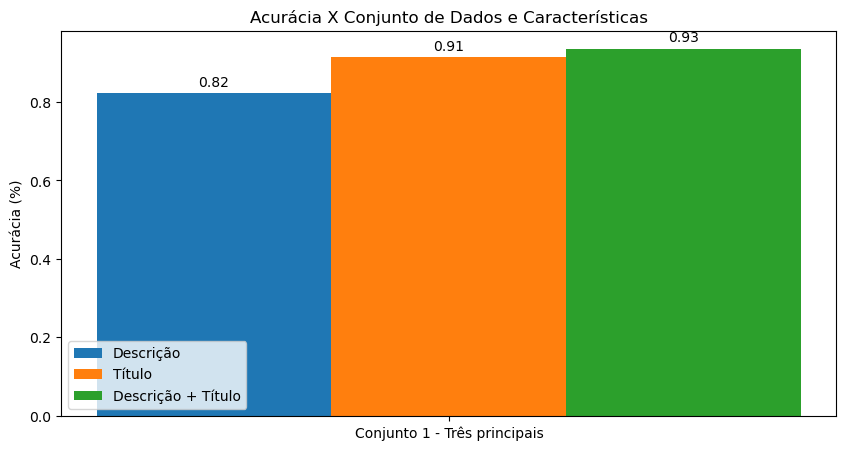

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
categorias = ['Conjunto 1 - Três principais']
x = np.arange(len(categorias))
width = 0.25

# uma barra para cada estratégia
rects1 = ax.bar(x - width, desc_acc1, width, label='Descrição')
rects2 = ax.bar(x, title_acc1, width, label='Título')
rects3 = ax.bar(x + width, full_acc1, width, label='Descrição + Título')

# rotulos + título
ax.set_ylabel('Acurácia (%)')
ax.set_title('Acurácia X Conjunto de Dados e Características')
ax.set_xticks(x)
ax.set_xticklabels(categorias)
ax.legend()

# adicionando os valores no topo das barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.show()

## Conjunto 2 - Todos menos os três principais

Criação de um vetor *tf-idf* para a descrição, titulo, e descrição + titulo juntos

#### Para descrição

In [35]:
tfidf_vector2desc = TfidfVectorizer()
tfidf_vector2desc.fit(dados_t2['desc_processado'])

train_X_tfidf_2desc = tfidf_vector2desc.transform(train_X2['desc_processado'])
test_X_tfidf_2desc = tfidf_vector2desc.transform(test_X2['desc_processado'])

dados_principais_tfidf_2desc = tfidf_vector2desc.transform(dados_t2['desc_processado'])

#### Para título

In [36]:
tfidf_vector2title = TfidfVectorizer()
tfidf_vector2title.fit(dados_t2['headline_processado'])

train_X_tfidf_2title = tfidf_vector2title.transform(train_X2['headline_processado'])
test_X_tfidf_2title = tfidf_vector2title.transform(test_X2['headline_processado'])

dados_principais_tfidf_2title = tfidf_vector2title.transform(dados_t2['headline_processado'])

#### Para descrição + título

In [37]:
tfidf_vector2full = TfidfVectorizer()
tfidf_vector2full.fit(dados_t2['texto_tot'])

train_X_tfidf_2full = tfidf_vector2full.transform(train_X2['texto_tot'])
test_X_tfidf_2full = tfidf_vector2full.transform(test_X2['texto_tot'])

dados_principais_tfidf_2full = tfidf_vector2full.transform(dados_t2['texto_tot'])

### Aplicando o modelo:

#### Para descrição

In [38]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_2desc, train_Y2)
predictions_svm = svm.predict(test_X_tfidf_2desc)
desc_acc2 = accuracy_score(predictions_svm, test_Y2)
print(f"Acurácia SVM: {desc_acc2*100:.3f}%")

Acurácia SVM: 39.771%


#### Para título

In [39]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_2title, train_Y2)
predictions_svm = svm.predict(test_X_tfidf_2title)
title_acc2 = accuracy_score(predictions_svm, test_Y2)
print(f"Acurácia SVM: {title_acc2*100:.3f}%")

Acurácia SVM: 57.019%


#### Para descrição + título

In [40]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_2full, train_Y2)
predictions_svm = svm.predict(test_X_tfidf_2full)
full_acc2 = accuracy_score(predictions_svm, test_Y2)
print(f"Acurácia SVM: {full_acc2*100:.3f}%")

Acurácia SVM: 57.553%


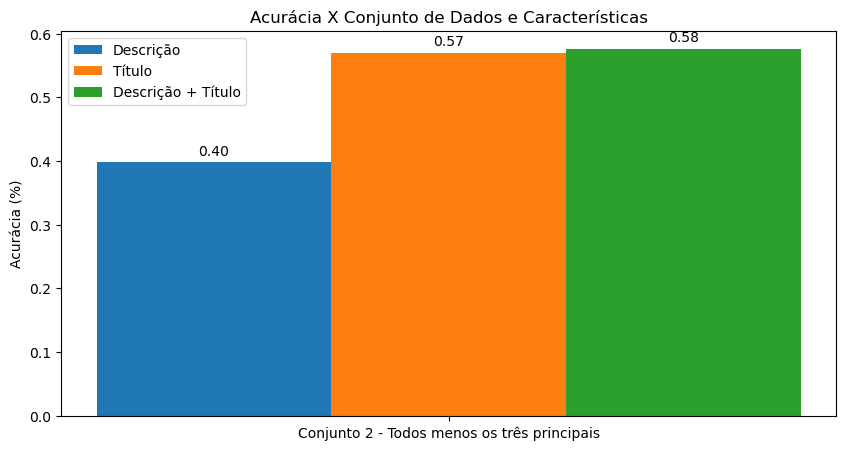

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
categorias = ['Conjunto 2 - Todos menos os três principais']
x = np.arange(len(categorias))
width = 0.25

# uma barra para cada estratégia
rects1 = ax.bar(x - width, desc_acc2, width, label='Descrição')
rects2 = ax.bar(x, title_acc2, width, label='Título')
rects3 = ax.bar(x + width, full_acc2, width, label='Descrição + Título')

# rotulos + título
ax.set_ylabel('Acurácia (%)')
ax.set_title('Acurácia X Conjunto de Dados e Características')
ax.set_xticks(x)
ax.set_xticklabels(categorias)
ax.legend()

# adicionando os valores no topo das barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.show()

## Conjunto 3 - 9 pricipais temas do Conjunto 2

Criação de um vetor *tf-idf* para a descrição, titulo, e descrição + titulo juntos

#### Para descrição

In [42]:
tfidf_vector3desc = TfidfVectorizer()
tfidf_vector3desc.fit(dados_t3['desc_processado'])

train_X_tfidf_3desc = tfidf_vector3desc.transform(train_X3['desc_processado'])
test_X_tfidf_3desc = tfidf_vector3desc.transform(test_X3['desc_processado'])

dados_principais_tfidf_3desc = tfidf_vector3desc.transform(dados_t3['desc_processado'])

#### Para título

In [43]:
tfidf_vector3title = TfidfVectorizer()
tfidf_vector3title.fit(dados_t3['headline_processado'])

train_X_tfidf_3title = tfidf_vector3title.transform(train_X3['headline_processado'])
test_X_tfidf_3title = tfidf_vector3title.transform(test_X3['headline_processado'])

dados_principais_tfidf_3title = tfidf_vector3title.transform(dados_t3['headline_processado'])

#### Para descrição + título

In [44]:
tfidf_vector3full = TfidfVectorizer()
tfidf_vector3full.fit(dados_t3['texto_tot'])

train_X_tfidf_3full = tfidf_vector3full.transform(train_X3['texto_tot'])
test_X_tfidf_3full = tfidf_vector3full.transform(test_X3['texto_tot'])

dados_principais_tfidf_3full = tfidf_vector3full.transform(dados_t3['texto_tot'])

### Aplicando o modelo:

#### Para descrição

In [45]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_3desc, train_Y3)
predictions_svm = svm.predict(test_X_tfidf_3desc)
desc_acc3 = accuracy_score(predictions_svm, test_Y3)
print(f"Acurácia SVM: {desc_acc3*100:.3f}%")

Acurácia SVM: 61.234%


#### Para título

In [46]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_3title, train_Y3)
predictions_svm = svm.predict(test_X_tfidf_3title)
title_acc3 = accuracy_score(predictions_svm, test_Y3)
print(f"Acurácia SVM: {title_acc3*100:.3f}%")

Acurácia SVM: 78.372%


#### Para descrição + título

In [47]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf_3full, train_Y3)
predictions_svm = svm.predict(test_X_tfidf_3full)
full_acc3 = accuracy_score(predictions_svm, test_Y3)
print(f"Acurácia SVM: {full_acc3*100:.3f}%")

Acurácia SVM: 79.490%


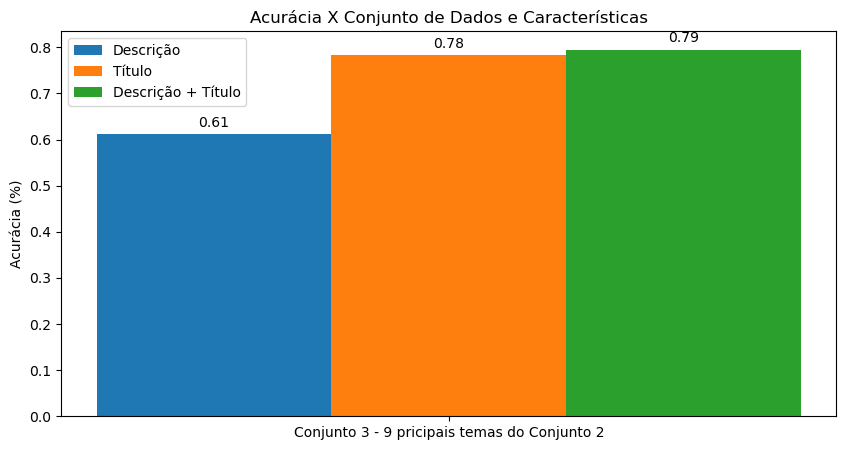

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
categorias = ['Conjunto 3 - 9 pricipais temas do Conjunto 2']
x = np.arange(len(categorias))
width = 0.25

# uma barra para cada estratégia
rects1 = ax.bar(x - width, desc_acc3, width, label='Descrição')
rects2 = ax.bar(x, title_acc3, width, label='Título')
rects3 = ax.bar(x + width, full_acc3, width, label='Descrição + Título')

# rotulos + título
ax.set_ylabel('Acurácia (%)')
ax.set_title('Acurácia X Conjunto de Dados e Características')
ax.set_xticks(x)
ax.set_xticklabels(categorias)
ax.legend()

# adicionando os valores no topo das barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.show()

## Conclusão

Após a análise dos três conjuntos de dados com diferentes estratégias de processamento de texto, podemos observar:

1. **Conjunto 1 (Três principais temas)**:
   - Melhor desempenho geral, com acurácia superior a 80% em todas as abordagens
   - A combinação de descrição + título obteve o melhor resultado
   - Isso sugere que temas mais amplos são mais facilmente distinguíveis

2. **Conjunto 2 (Todos menos os três principais)**:
   - Desempenho mais baixo em comparação com o Conjunto 1
   - Maior complexidade devido ao número de categorias
   - A diferença entre usar apenas título ou apenas descrição é menor

3. **Conjunto 3 (9 principais temas do Conjunto 2)**:
   - Desempenho intermediário
   - Melhor que o Conjunto 2 completo, mas inferior ao Conjunto 1
   - Demonstra que reduzir o número de categorias melhora a precisão

**Observações Gerais:**
- A combinação de título e descrição consistentemente oferece os melhores resultados
- Quanto menor o número de categorias, melhor o desempenho do classificador
- O SVM mostrou-se eficaz para esta tarefa de classificação multiclasse
- A diferença de desempenho entre usar apenas título ou apenas descrição varia conforme o conjunto

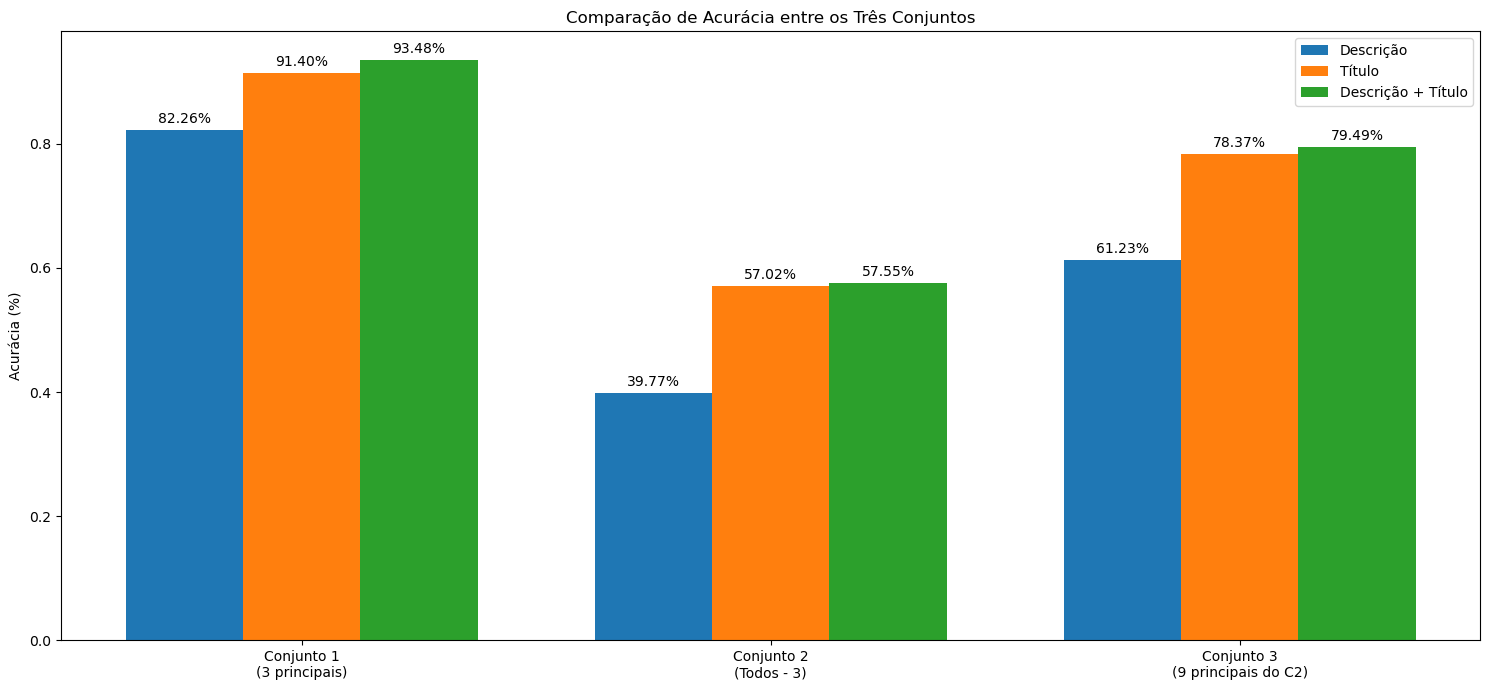

In [49]:
fig, ax = plt.subplots(figsize=(15, 7))
categorias = ['Conjunto 1\n(3 principais)', 'Conjunto 2\n(Todos - 3)', 'Conjunto 3\n(9 principais do C2)']
x = np.arange(len(categorias))
width = 0.25

desc_accuracies = [desc_acc1, desc_acc2, desc_acc3]
title_accuracies = [title_acc1, title_acc2, title_acc3]
full_accuracies = [full_acc1, full_acc2, full_acc3]

rects1 = ax.bar(x - width, desc_accuracies, width, label='Descrição')
rects2 = ax.bar(x, title_accuracies, width, label='Título')
rects3 = ax.bar(x + width, full_accuracies, width, label='Descrição + Título')

ax.set_ylabel('Acurácia (%)')
ax.set_title('Comparação de Acurácia entre os Três Conjuntos')
ax.set_xticks(x)
ax.set_xticklabels(categorias)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.tight_layout()
plt.show()